In [ ]:
import torch
import shutil

In [ ]:
source_path = '/content/drive/MyDrive/drivingspacedetection.zip'
destination_path = '/content/drivingspacedetection.zip'

In [ ]:
shutil.copy(source_path, destination_path)
# Unzip the downloaded file
!unzip -q drivingspacedetection.zip -d drivingspacedetection && rm drivingspacedetection.zip # unzip

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-cv.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import pandas as pd
import os
import warnings
import logging
from IPython.display import clear_output
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import keras_cv
import tensorflow as tf
from tensorflow import keras
from transformers import TFSegformerForSemanticSegmentation

Using TensorFlow backend


In [ ]:
# Suppress warnings and logging messages
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.disable(logging.WARNING)

In [ ]:
# Set up distributed strategy
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    [tf.config.experimental.set_memory_growth(pd, True) for pd in physical_devices]
    strategy = tf.distribute.MirroredStrategy()
except:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    keras.mixed_precision.set_global_policy("mixed_bfloat16")

In [ ]:
data_path = '/content/drivingspacedetection/drivingspacedetection/'
exts = ('jpg', 'JPG', 'png', 'PNG',)
image_path = os.path.join(data_path, 'IMAGES', 'train')
label_path = os.path.join(data_path, 'LABELS', 'train')

In [ ]:
# Load images and masks
images = sorted(
    [
        os.path.join(image_path, fname)
        for fname in os.listdir(image_path)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

masks = sorted(
    [
        os.path.join(label_path, fname)
        for fname in os.listdir(label_path)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

In [ ]:
# Display information about the number of samples and paths
print("Number of samples:", len(images), len(masks))
for input_path, target_path in zip(images[:10], masks[:10]):
    print(input_path[-28:], "|", target_path[-37:])

Number of samples: 70000 70000
/train/0000f77c-6257be58.jpg | on/LABELS/train/0000f77c-6257be58.png
/train/0000f77c-62c2a288.jpg | on/LABELS/train/0000f77c-62c2a288.png
/train/0000f77c-cb820c98.jpg | on/LABELS/train/0000f77c-cb820c98.png
/train/0001542f-5ce3cf52.jpg | on/LABELS/train/0001542f-5ce3cf52.png
/train/0001542f-7c670be8.jpg | on/LABELS/train/0001542f-7c670be8.png
/train/0001542f-ec815219.jpg | on/LABELS/train/0001542f-ec815219.png
/train/0004974f-05e1c285.jpg | on/LABELS/train/0004974f-05e1c285.png
/train/00054602-3bf57337.jpg | on/LABELS/train/00054602-3bf57337.png
/train/00067cfb-5443fe39.jpg | on/LABELS/train/00067cfb-5443fe39.png
/train/00067cfb-5adfaaa7.jpg | on/LABELS/train/00067cfb-5adfaaa7.png


In [ ]:
# Display function for images and masks
def display(display_list, extra_title=''):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']

    if len(display_list) > len(title):
        title.append(extra_title)

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy().astype(np.uint8), cmap='viridis')
        plt.axis('off')
    plt.show()


In [ ]:
id2label = {
    0:  'direct',
    1:  'alternative',
    2:  'background',
}
label2id = { label: id for id, label in id2label.items() }
CLASSES = len(id2label)
CLASSES

3

In [ ]:
# Train-test split
train_img, test_img, train_msk, test_msk = train_test_split(
    images, masks, test_size=0.20, random_state=42
)

In [ ]:
# Image size and batch size
IMAGE_SIZE = 256
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Read files function
def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.resize(
            images=image,
            size=[IMAGE_SIZE, IMAGE_SIZE],
            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
        )
        image = tf.where(image == 255, np.dtype('uint8').type(0), image)
        image = tf.cast(image, tf.float32)

        # Add a mapping function to handle label values outside the range
        image = tf.map_fn(lambda x: x % CLASSES, image, dtype=tf.float32)

    else:
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.float32)
    return image

In [ ]:
# Load data function for Keras CV
def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask = read_files(mask_list, mask=True)
    return image, mask

# Data generator function for Keras CV
def data_generator_kcv(image_list, mask_list, split='train'):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(10 * BATCH_SIZE) if split == 'train' else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset.prefetch(tf.data.AUTOTUNE)


In [ ]:
# Create Keras CV datasets
train_ds_kcv = data_generator_kcv(train_img, train_msk)
val_ds_kcv = data_generator_kcv(test_img, test_msk, split='validation')

(16, 256, 256, 3) (16, 256, 256, 1)


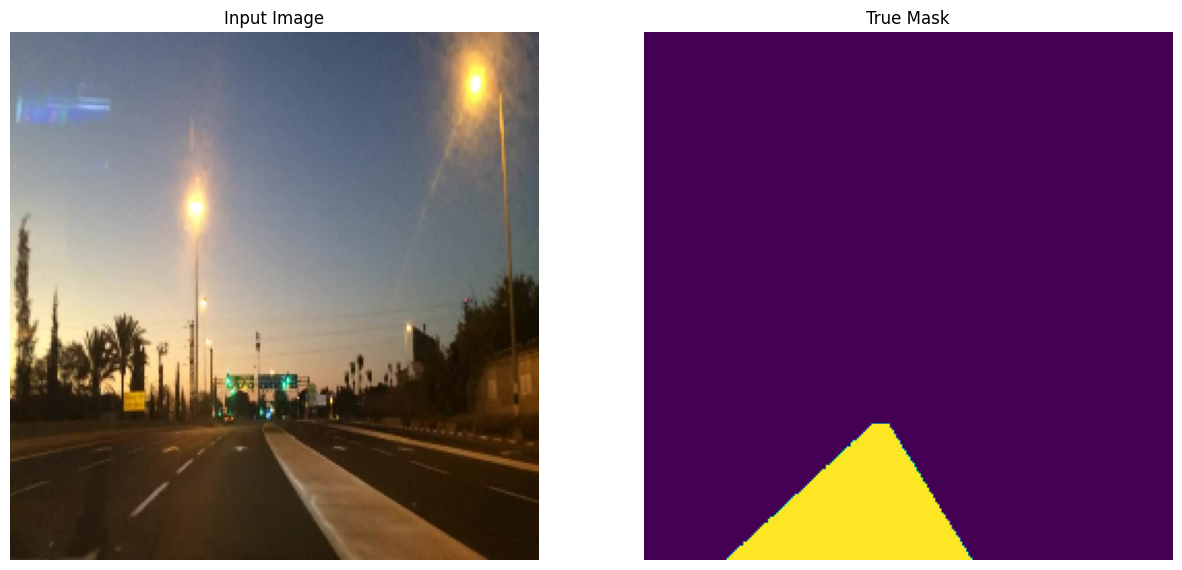

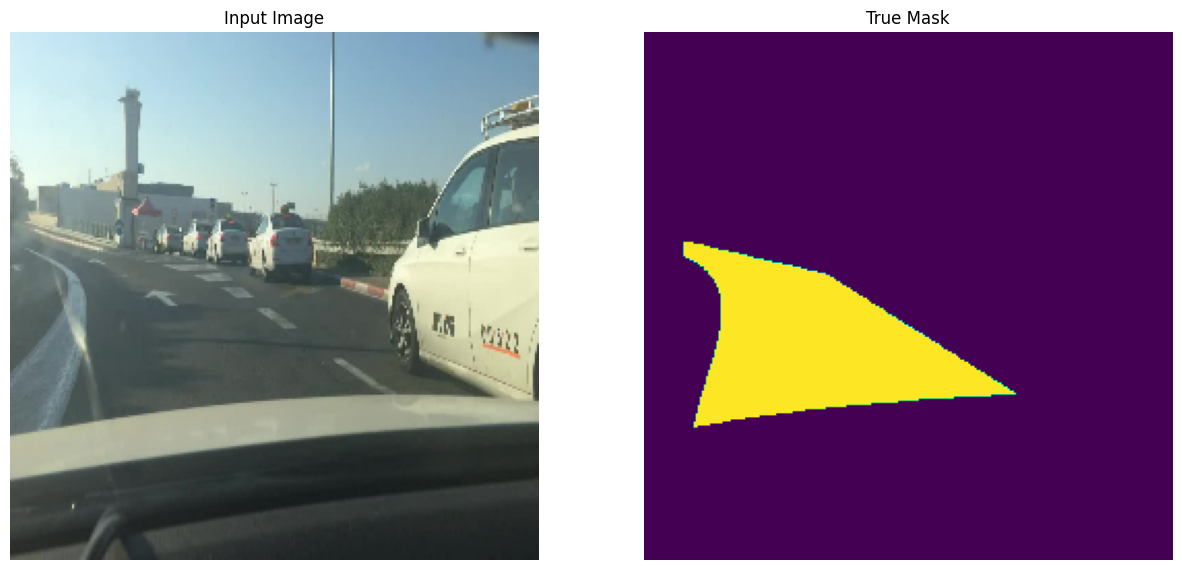

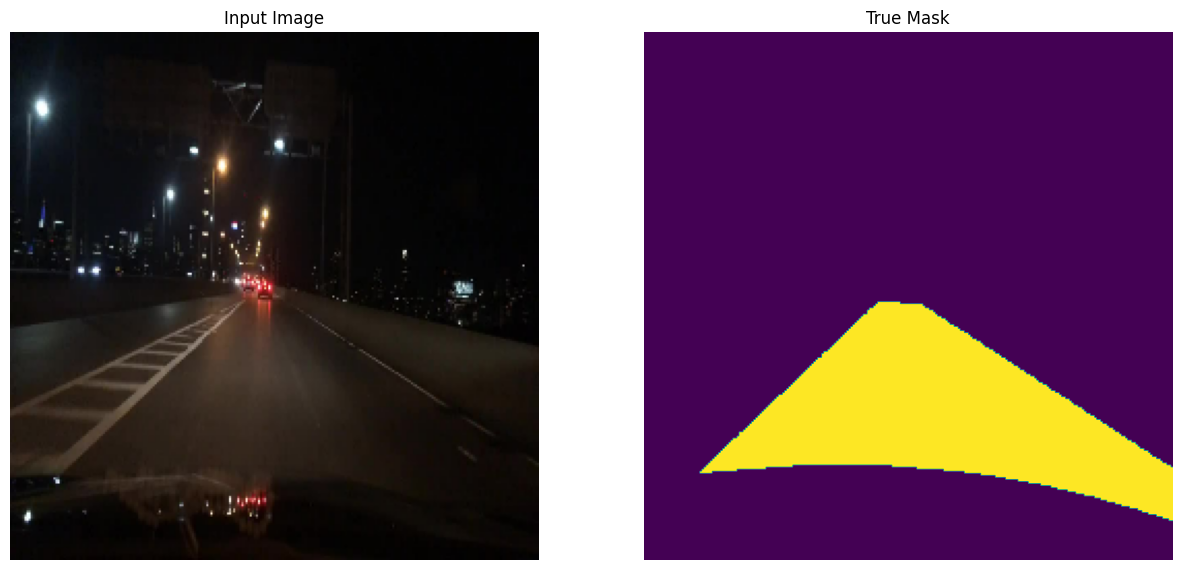

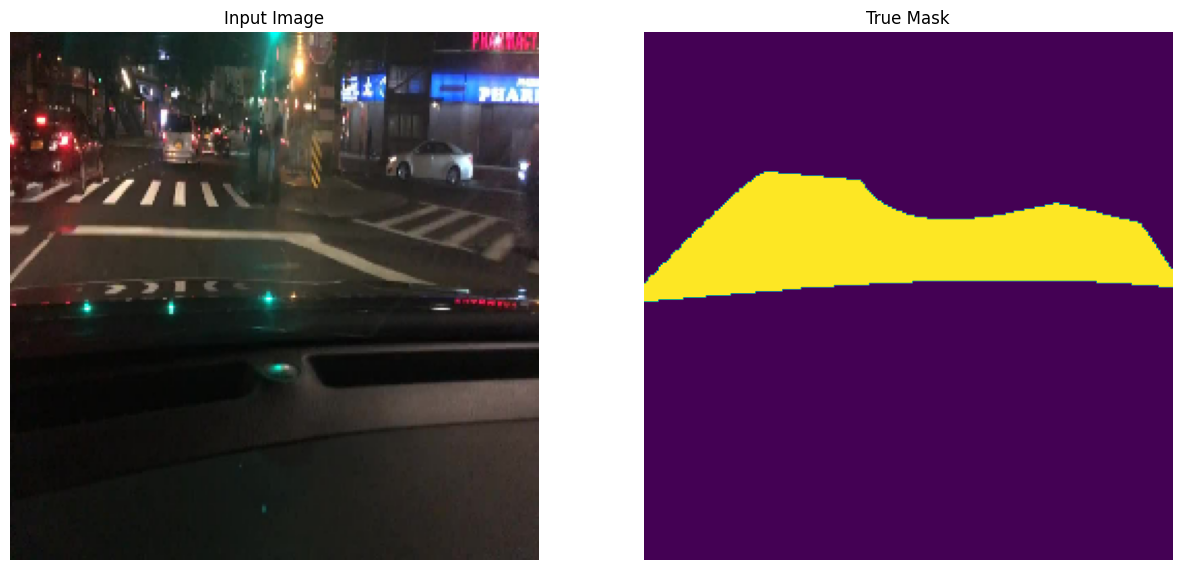

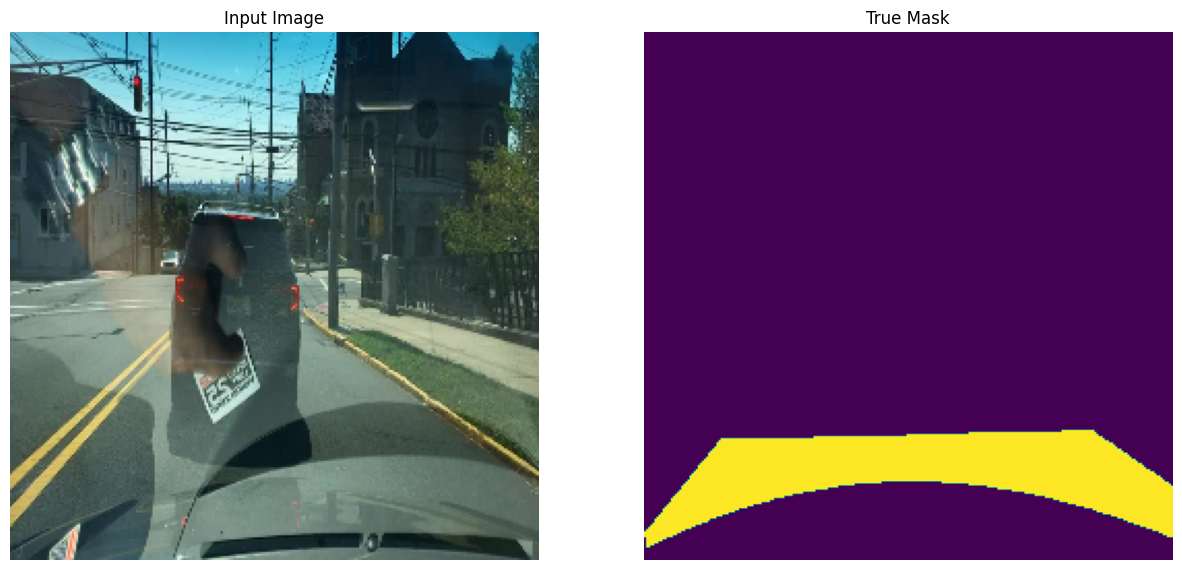

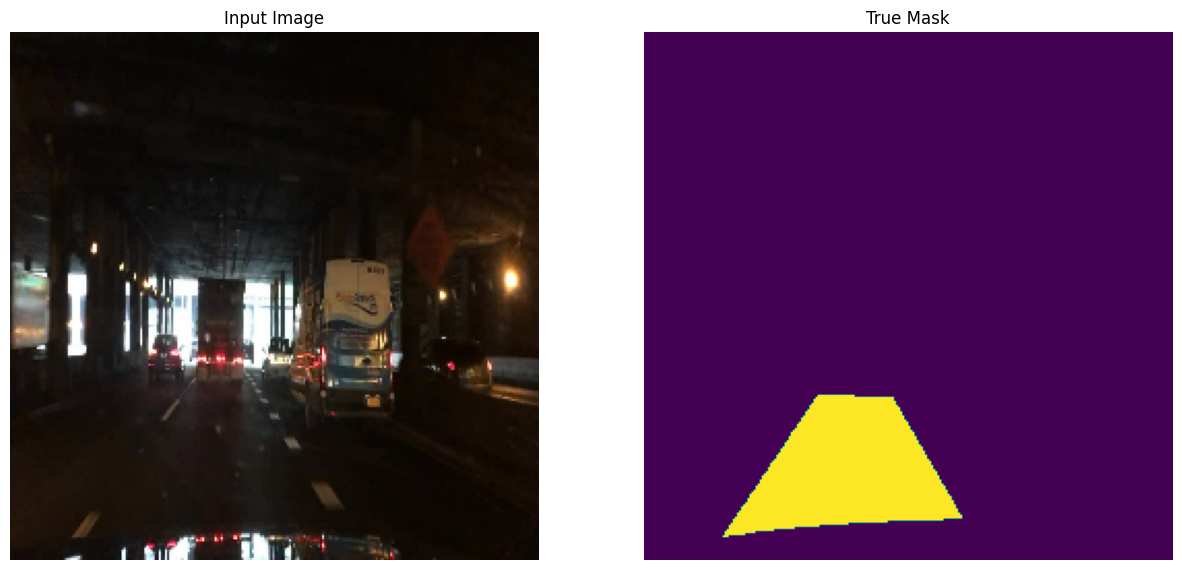

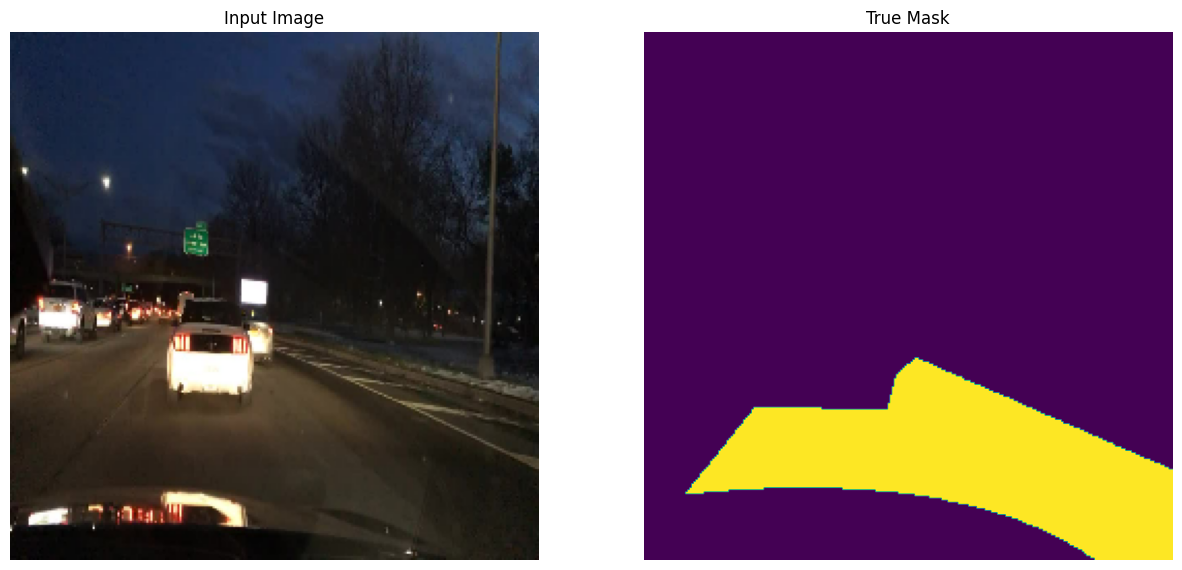

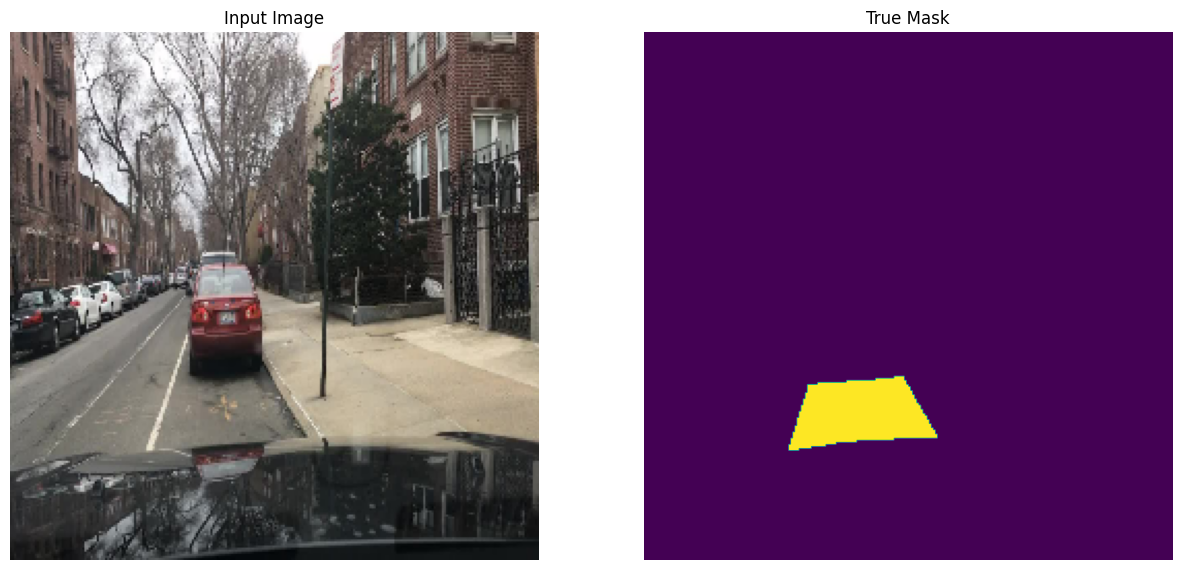

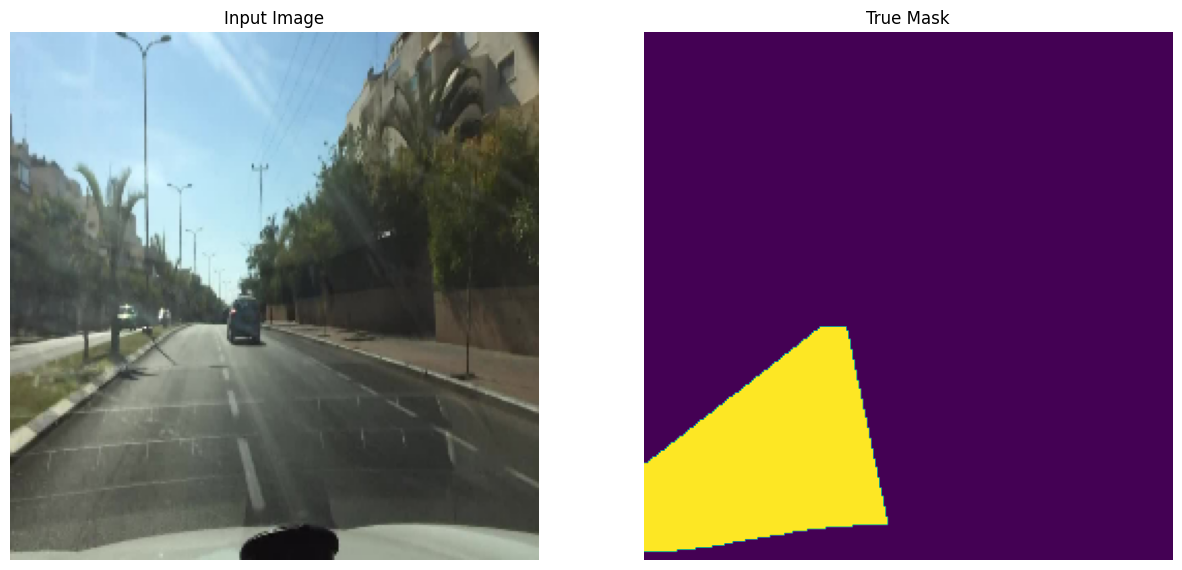

In [ ]:
X, Y = next(iter(val_ds_kcv))
print(X.shape, Y.shape)

for x, y in zip(X, Y):
    display([x, y])

In [ ]:
# Load data function for HF
def load_data_HF(image_list, mask_list):
    image = read_files(image_list)
    mask = read_files(mask_list, mask=True)
    image = tf.transpose(image, (2, 0, 1))
    mask = tf.squeeze(mask)

    # Add a mapping function to handle label values outside the range
    mask = tf.map_fn(lambda x: x % CLASSES, mask, dtype=tf.float32)

    return {
        "pixel_values": image,
        "labels": mask
    }


In [ ]:

def data_generator_HF(image_list, mask_list, split='train'):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(10 * BATCH_SIZE) if split == 'train' else dataset
    dataset = dataset.map(load_data_HF, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create HF datasets
train_ds_hf = data_generator_HF(train_img, train_msk)
val_ds_hf = data_generator_HF(test_img, test_msk, split='validation')

# Model checkpoint and global policy
model_checkpoint = "nvidia/mit-b0"
keras.mixed_precision.set_global_policy("float32")

In [ ]:
# Build and compile the model using TFSegformerForSemanticSegmentation
with strategy.scope():
    model_hf = TFSegformerForSemanticSegmentation.from_pretrained(
        model_checkpoint,
        num_labels=CLASSES,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )

    optim = keras.optimizers.Adam(0.001)
    model_hf.compile(optimizer=optim)


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

In [ ]:
# Fit the model
model_hf.fit(
    train_ds_hf,
    validation_data=val_ds_hf,
    epochs=5
)

Epoch 1/5
3500/3500 [==============================] - 1951s 531ms/step - loss: 0.1103 - val_loss: 0.0823
Epoch 2/5
3500/3500 [==============================] - 1833s 524ms/step - loss: 0.0856 - val_loss: 0.0815
Epoch 3/5
3500/3500 [==============================] - 1901s 543ms/step - loss: 0.0798 - val_loss: 0.0752
Epoch 4/5
3500/3500 [==============================] - 1810s 517ms/step - loss: 0.0755 - val_loss: 0.0736
Epoch 5/5
3500/3500 [==============================] - 1796s 513ms/step - loss: 0.0724 - val_loss: 0.0717


In [26]:
val = val_ds_hf.take(1)
X = iter(val).next()['pixel_values']
Y = iter(val).next()['labels']

Y_PRED = model_hf.predict(X)
Y_PRED = tf.transpose(
    Y_PRED.logits,     # shape. [batch_size, channel, h, w]
    perm=[0, 2, 3, 1]
)

# Y_PRED.shape: TensorShape([16, 56, 56, 19])
# In HF, logits are of shape (batch_size, num_labels, height/4, width/4)
Y_PRED = keras.layers.UpSampling2D(size=(4, 4))(Y_PRED)
Y_PRED = tf.math.argmax(Y_PRED, axis=-1)

X = tf.transpose(
    X,  # shape. [batch_size, channel, h, w]
    perm=[0, 2, 3, 1]
)
print(X.shape, Y.shape, Y_PRED.shape)

1/1 [==============================] - 0s 108ms/step
(16, 256, 256, 3) (16, 256, 256) (16, 256, 256)


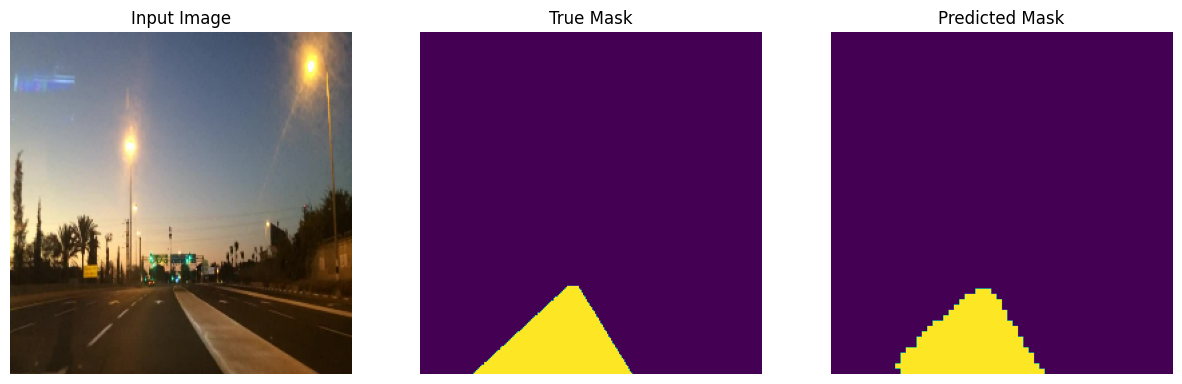

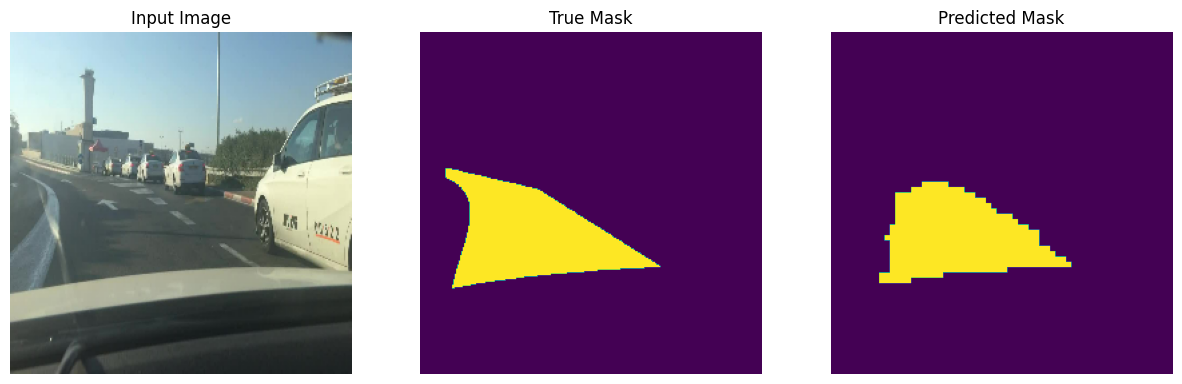

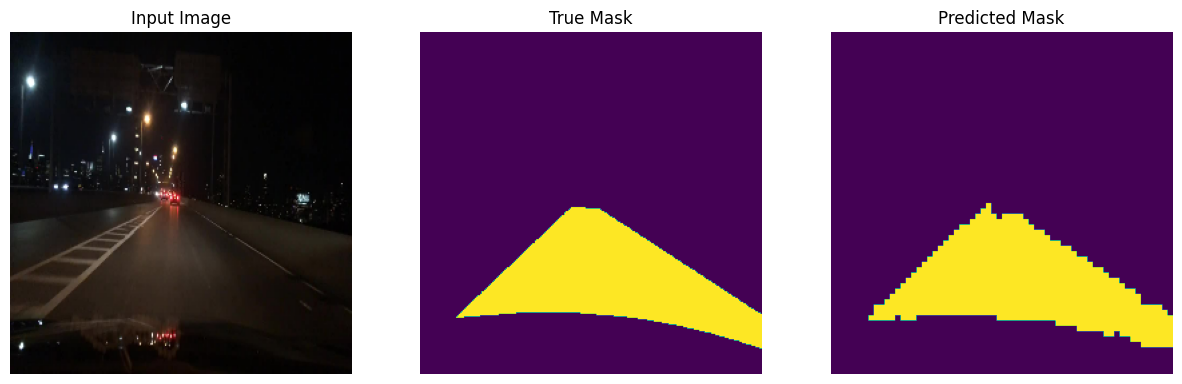

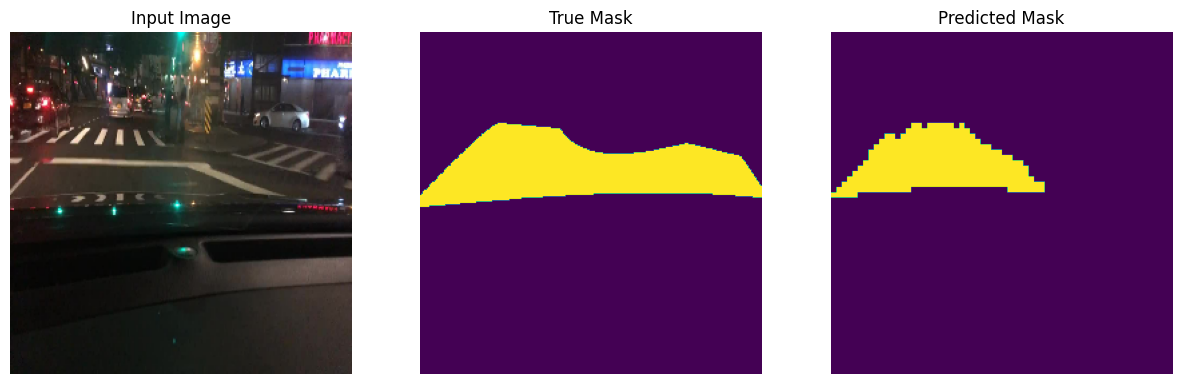

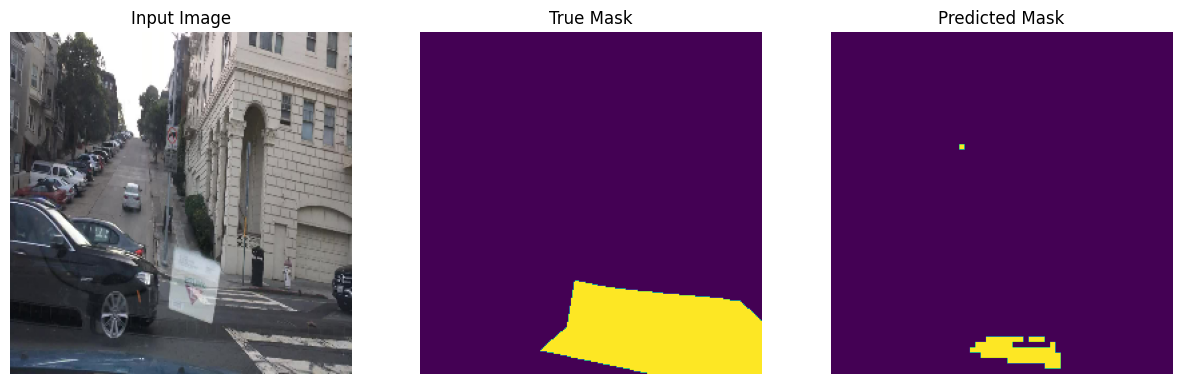

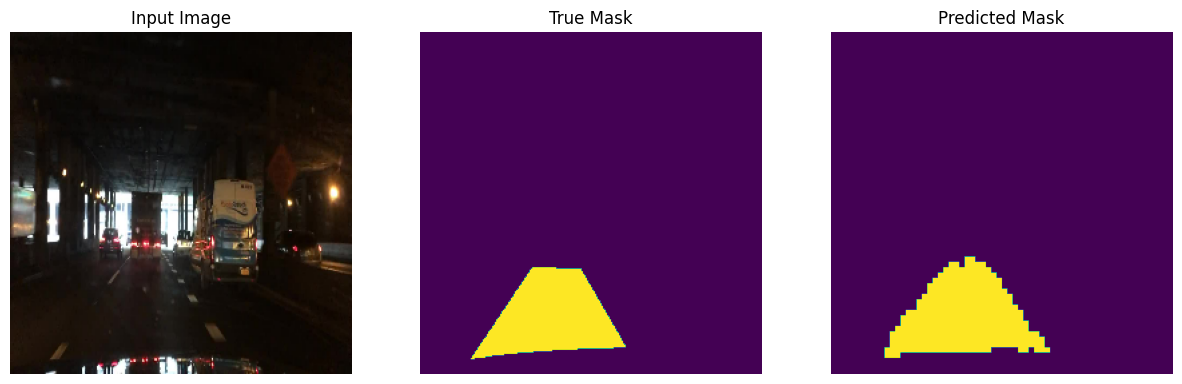

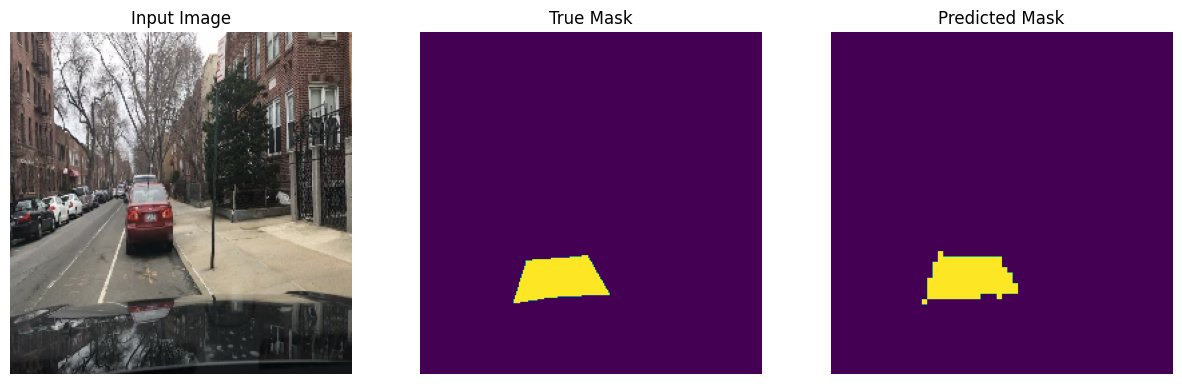

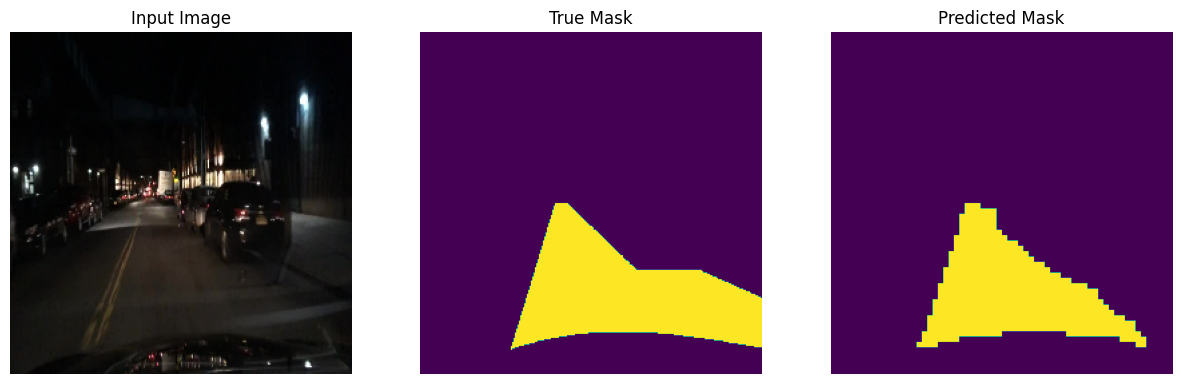

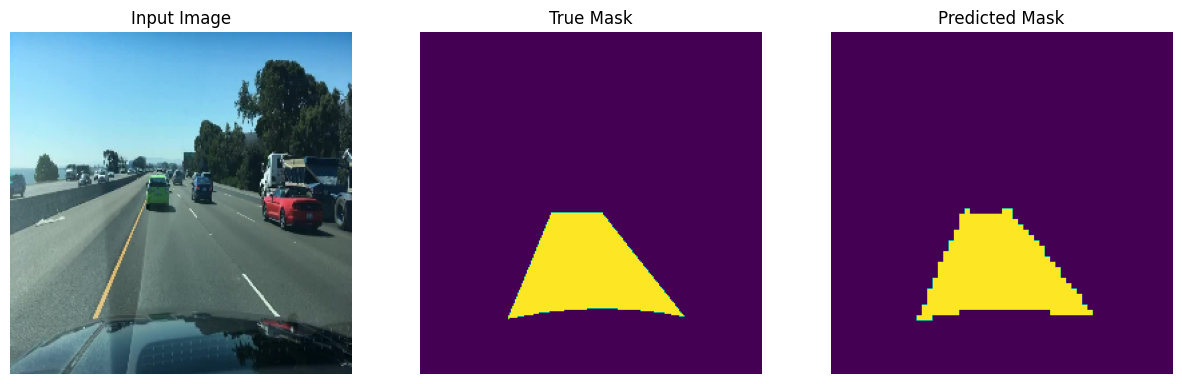

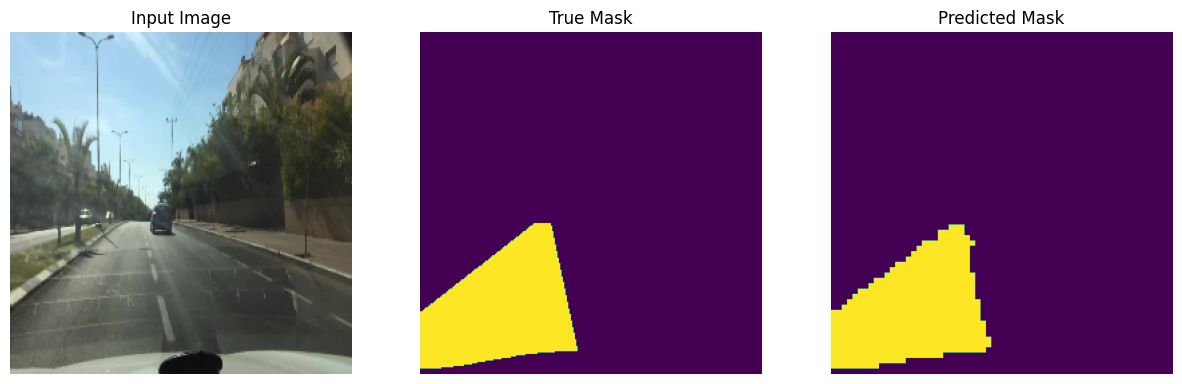

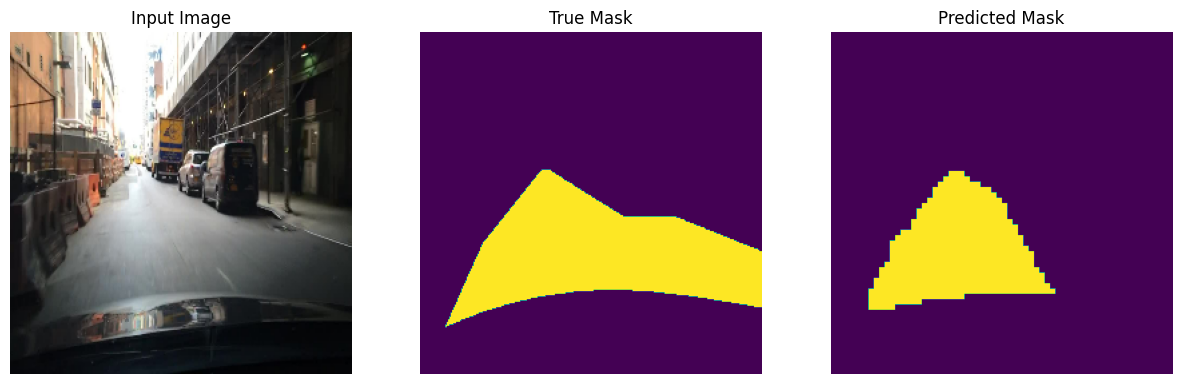

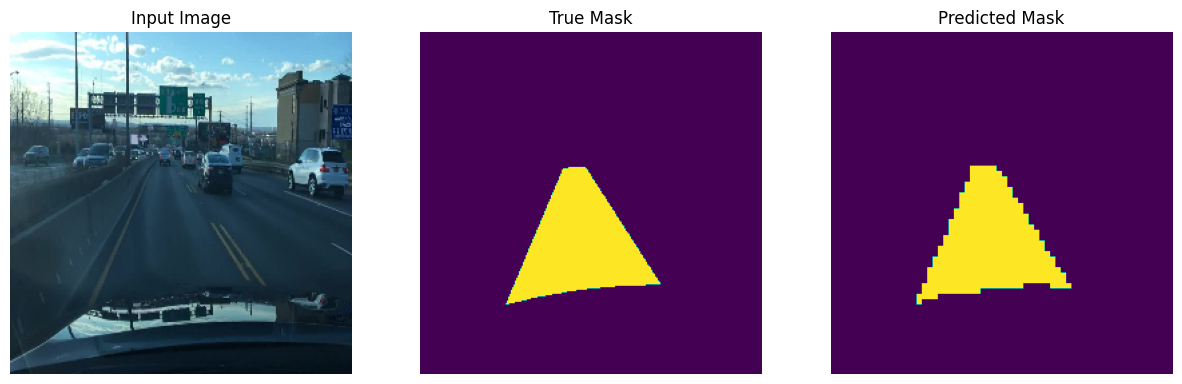

In [ ]:
for x, y, y_pred in zip(X, Y, Y_PRED):
    display([x, y, y_pred], extra_title='Predicted Mask')

1/1 [==============================] - 0s 162ms/step
(16, 256, 256, 3) (16, 256, 256) (16, 256, 256)


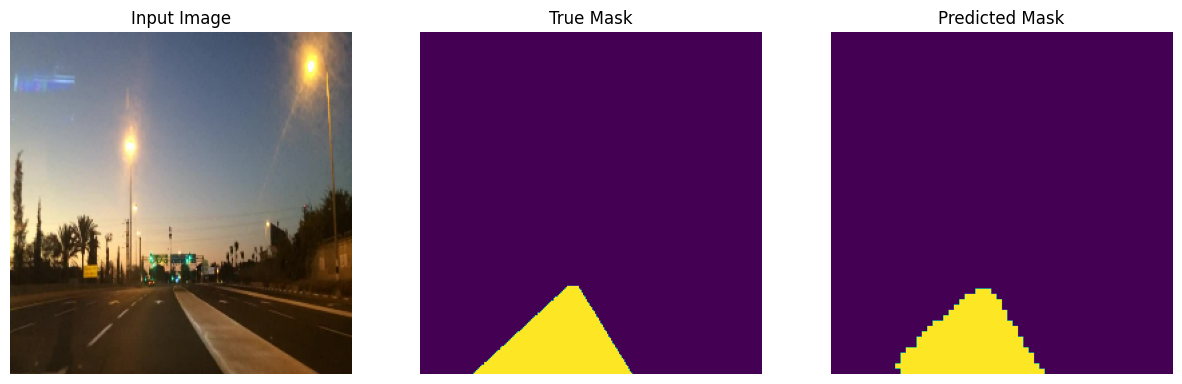

In [27]:
# Extract a batch from the validation dataset
val = val_ds_hf.take(1)
X = iter(val).next()['pixel_values']
Y = iter(val).next()['labels']

# Predict using the trained model
Y_PRED = model_hf.predict(X)

# Transpose the predicted logits to the required shape
Y_PRED = tf.transpose(
    Y_PRED.logits,     # shape: [batch_size, channel, h, w]
    perm=[0, 2, 3, 1]
)

# Upsample the predictions to match the input image size
Y_PRED = keras.layers.UpSampling2D(size=(4, 4))(Y_PRED)

# Argmax to get the predicted class labels
Y_PRED = tf.math.argmax(Y_PRED, axis=-1)

# Transpose the input image to the required shape
X = tf.transpose(
    X,  # shape: [batch_size, channel, h, w]
    perm=[0, 2, 3, 1]
)

# Display shapes
print(X.shape, Y.shape, Y_PRED.shape)

# Display the input image, true mask, and predicted mask
display([X[0], Y[0], Y_PRED[0]], extra_title='Predicted Mask')
